for the smaller dataset the commonly use techniques to increesae the performance is to use the pretrained model that is trained over a huge dataset. The convnet part in trained network shows more generic features and can be used for new task even the task is completely different from the earlier performed task. The fully connected layers after the conv layers are act as a classifier and its features are more related to abstract features and can be treated as problem specific faetures so, in order to take advantage of already trained model we can do two things:
* remove the fully connected layers and take the conv layers as a feature extraction layers 
* freeze the starting conv layers and traing the classifier 

1) We use the VGG16 as a feature extractor 

In [1]:
from keras.applications import VGG16

In [3]:
conv_base = VGG16(weights='imagenet',include_top = False, input_shape= (150,150,3))

58892288/58889256 [==============================] - 83s 1us/step


Model Summary

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

There are two ways to utilize the above network:
* Pass the whole data and get the features in the tensor of (4,4,512) and then feed that data to classifier but this approah restrict us to use the data augmentation 
* secondly stack new fully connected layers on top of that and freeze the conv layers and train the whole model

1) Fast feature extraction without data augmentation 

In [5]:
# Extracting features with pretrained model

In [6]:
import os 
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [9]:
base_dir = 'C:/Users/Haier/Dataset/dogs-vs-cats/cats_and_dogs_small'

In [18]:
train_dir = os.path.join(base_dir,'train').replace('\\','/')

In [19]:
train_dir

'C:/Users/Haier/Dataset/dogs-vs-cats/cats_and_dogs_small/train'

In [21]:
validation_dir = os.path.join(base_dir,'validation').replace('\\','/')

In [22]:
validation_dir

'C:/Users/Haier/Dataset/dogs-vs-cats/cats_and_dogs_small/validation'

In [25]:
test_dir = os.path.join(base_dir,'test').replace('\\','/')

In [26]:
test_dir

'C:/Users/Haier/Dataset/dogs-vs-cats/cats_and_dogs_small/test'

In [27]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [32]:
def extract_features(directory,sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,target_size=(150,150),
                                            batch_size=batch_size,
                                           class_mode='binary')
    i=0

    for input_batch, labels_batch in generator:
        feature_batch = conv_base.predict(input_batch)
        features[i*batch_size:(i+1)*batch_size] = feature_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i+=1
        if i*batch_size>=sample_count:
            break
    return features,labels


In [33]:
train_features, train_labels = extract_features(train_dir,2000)
validation_features, validation_labels = extract_features(validation_dir,1000)
test_features, test_labels = extract_features(test_dir,1000)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [35]:
train_features = np.reshape(train_features,(2000,4*4*512))

validation_features = np.reshape(validation_features,(1000,4*4*512))

test_features = np.reshape(test_features,(1000,4*4*512))

In [36]:
train_features.shape

(2000, 8192)

Defining Classifier 

In [34]:
from keras import models
from keras import layers
from keras import optimizers

In [37]:
model = models.Sequential()

model.add(layers.Dense(256,activation='relu',input_dim=(4*4*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [38]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])

In [39]:
history = model.fit(train_features,train_labels,epochs=30,batch_size=20,
                   validation_data=(validation_features,validation_labels))

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 7s 3ms/step - loss: 0.5983 - acc: 0.6720 - val_loss: 0.4334 - val_acc: 0.8430
Epoch 2/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.4235 - acc: 0.8140 - val_loss: 0.3559 - val_acc: 0.8790
Epoch 3/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.3592 - acc: 0.8485 - val_loss: 0.3219 - val_acc: 0.8770
Epoch 4/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.3089 - acc: 0.8705 - val_loss: 0.3040 - val_acc: 0.8780
Epoch 5/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.2800 - acc: 0.8885 - val_loss: 0.2851 - val_acc: 0.8930
Epoch 6/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.2627 - acc: 0.8950 - val_loss: 0.2746 - val_acc: 0.8950
Epoch 7/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.2460 - acc: 0.9010 - v

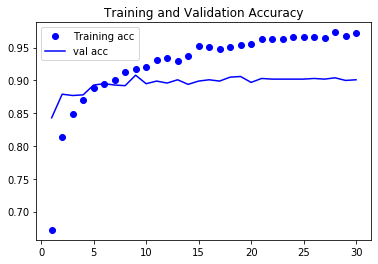

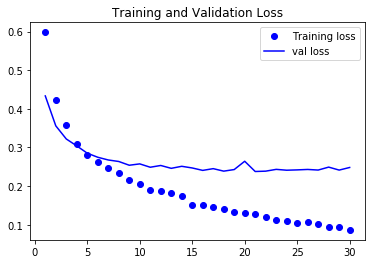

In [41]:
import matplotlib.pyplot as plt

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

train_loss = history.history['loss']
train_acc = history.history['acc']

epochs= range(1,len(train_acc)+1)

plt.plot(epochs,train_acc,'bo',label = 'Training acc')
plt.plot(epochs,val_acc,'b',label = 'val acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(epochs,train_loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'val loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Anaysis : As you can see that with this technqiue we achieve validation accuracy of 90% from the start that is much better then previous cases but its starts overfitting from the begining due to small dataset so we can avoid this overfitting by introducing the data augmentation technqiue 

2) Adding a densely connected classifier on a top of conv layer (Use Data Augmentation)

In [42]:
from keras import models 
from keras import layers

In [43]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [45]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range= 40,
                                  width_shift_range= 0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
                                 

In [46]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [47]:
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(150,150),
                                                   batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.


In [48]:
validation_generator = test_datagen.flow_from_directory(validation_dir,target_size=(150,150),
                                                       batch_size=20,
                                                       class_mode='binary')

Found 1000 images belonging to 2 classes.


In [49]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])

In [51]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs = 10,
                             validation_data=validation_generator,
                             validation_steps=50)

'history = model.fit_generator(train_generator,\n                             steps_per_epoch=100,\n                             epochs = 10,\n                             validation_data=validation_generator,\n                             validation_steps=50)'

In [54]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Analysis: By above model we can achieve the accuracy of 96%. This is much better then the accuracy of training from scratch. The above technqiue is preferable when we have small dataset to achieve good results and use of GPU is recommended due to a lot of parameters.

<------------------------------------------------------------------------- End ----------------------------------------------------->